In [1]:
import numpy as np
import scipy as sp  
import sys, json, os
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append('../../')
from project.recoil import Electron as El
from project.recoil import Nuclear as Nr
from project.recoil import p50, get_vdf_ert

In [2]:
MWdict = pickle.load(open('../../Output/MW_dict.pkl','rb'))
MWlike = pickle.load(open('../../Output/MWlike_dict.pkl','rb'))
mwld = MWlike['vdf_RCfit']
mwd = mwld['MW']
mwp = MWdict['vdf_PBRCfit']
mwgals = MWlike['mwgals']

### Example: Standard Halo Model

In [3]:
vgal = np.linspace(1e-5,1e3,1000)
fshm = np.exp(-(vgal/220)**2)
fshm[vgal>544.] = 0
fgal = vgal**2 * fshm
fgal = fgal/np.trapz(fgal,vgal)
vE= np.linspace(1e-5,1000,1000)
fE = get_vdf_ert(vE, vgal, fgal, 544., 220.)

el = El('Si', vE, fE, 544., 220., 0.4)
Ee = np.linspace(0,49,50)

In [4]:
mdm, sdm, bl = 5., 1e-38, 1.
nsg = el.totNsg(mdm, sdm, exposure=1.)
print (nsg)

1620.4597123952512


In [5]:
%%time
rate_sg = el.diffSg(mdm, sdm, Ee=Ee)
rate_bg = el.diffBg(bl, Ee=Ee)
rate_tot = el.diffTot(mdm, sdm, bl, Ee=Ee)

CPU times: user 6.48 s, sys: 6.67 ms, total: 6.48 s
Wall time: 6.48 s


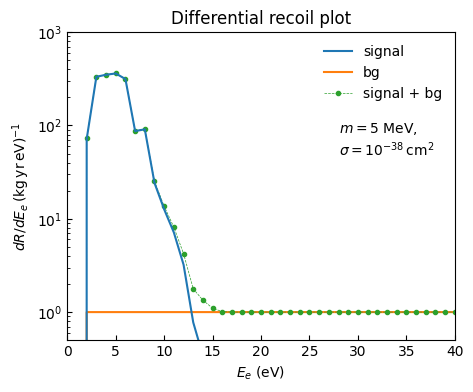

In [6]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(Ee, rate_sg, label='signal', zorder=1)
ax.plot(Ee, rate_bg, label='bg', zorder=0)
ax.plot(Ee, rate_tot, marker='.', label='signal + bg', zorder=0, ls='--', lw=0.5)
ax.legend(loc='upper right', frameon=False)

ax.set_yscale('log')
ax.set_ylim(5e-1,1e3)
ax.set_xlim(0,40)
ax.tick_params(which='both', direction='in')

ax.set_xlabel('$E_e$ (eV)')
ax.set_ylabel('$dR/dE_e \, (\mathrm{kg\, yr\, eV})^{-1}$')
ax.text(0.7, 0.6, '$m = %i$ MeV, \n$\sigma = 10^{%i}\, \mathrm{cm}^2$'%(mdm, np.log10(sdm)), transform=ax.transAxes)
ax.set_title('Differential recoil plot');
plt.savefig('../../Output/figures/recoil/el_diff_recoil.png', bbox_inches='tight', dpi=300)

In [7]:
bint_sg = el.binTot(mdm, sdm, 0., binwidth=3.8)
bint_bg = el.binTot(mdm, 0., bl, binwidth=3.8)
bint_tot = el.binTot(mdm, sdm, bl, binwidth=3.8)

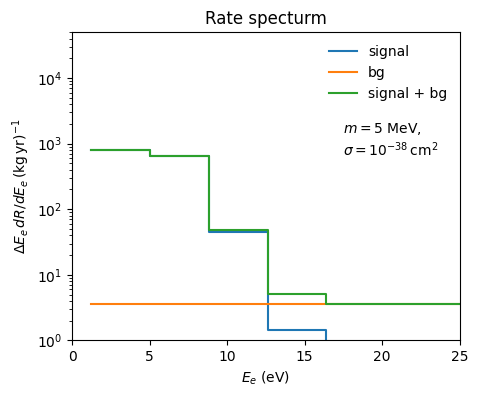

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
ax.step(bint_sg['E_edges'], bint_sg['Neachbin'], where='post', label='signal')
ax.step(bint_bg['E_edges'], bint_bg['Neachbin'], where='post', label='bg')
ax.step(bint_tot['E_edges'], bint_tot['Neachbin'], where='post', label='signal + bg')
ax.legend(loc = 'upper right', frameon=False)

ax.set_yscale('log')
ax.set_ylim(1e0,5e4)
ax.set_xlim(0,25)
ax.set_xlabel('$E_e$ (eV)')
ax.set_ylabel('$\Delta E_e \, dR/dE_e \, (\mathrm{kg\, yr})^{-1}$')
ax.text(0.7, 0.6, '$m = %i$ MeV, \n$\sigma = 10^{%i}\, \mathrm{cm}^2$'%(mdm, np.log10(sdm)), transform=ax.transAxes)
ax.set_title('Rate specturm')
plt.savefig('../../Output/figures/recoil/el_rate_spectrum.png', bbox_inches='tight', dpi=300)

In [9]:
Mdm = np.logspace(0,3,10)
Sdm_1 = el.sdmMdmNsg(Mdm, exposure=1, Ne_thr=3)
Sdm_10 = el.sdmMdmNsg(Mdm, exposure=10)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1e-43, 1e-38)

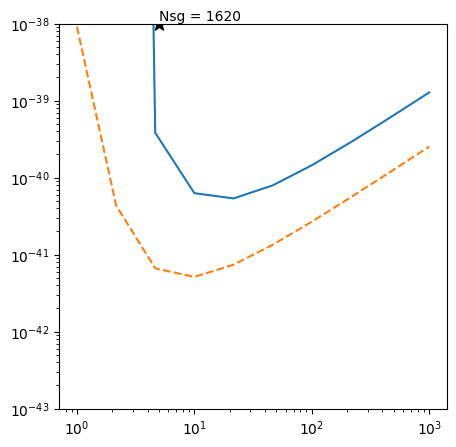

In [10]:
from matplotlib import markers


fig, ax = plt.subplots(figsize=(5,5))
ax.plot(Mdm, Sdm_1)
ax.plot(Mdm, Sdm_10, ls='--')

ax.scatter(mdm, sdm, c='k', marker='*', s=100)
ax.text(mdm, sdm*1.1, 'Nsg = %i'%nsg)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-43,1e-38)

In [11]:
mock = el.mocksample(mdm, sdm, bl, 3.8, exposure=10., seed = 5111)

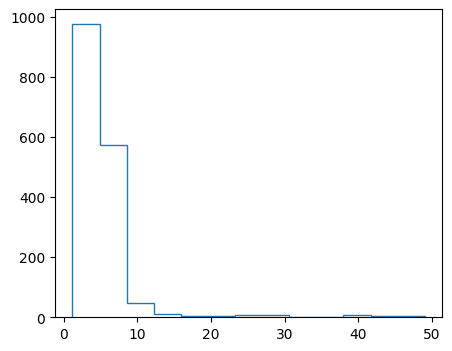

In [12]:
fig,ax = plt.subplots(figsize = (5,4))

ax.hist(mock['Eesample'], bins=mock['bin_edges'], histtype='step');

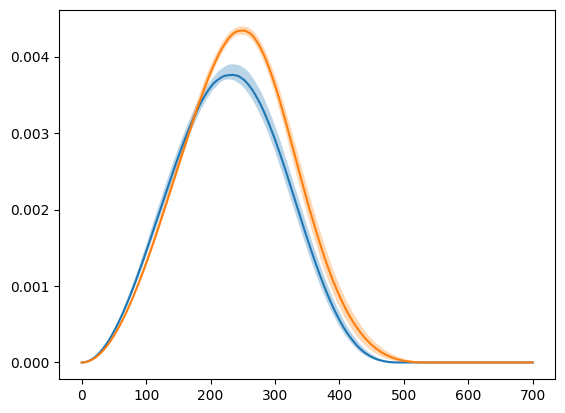

In [13]:
plt.plot(mwd['v'], mwd['vdf_50'])
plt.fill_between(mwd['v'], mwd['vdf_16'], mwd['vdf_84'], alpha=0.3)
plt.plot(mwp['v'], mwp['vdf_50'])
plt.fill_between(mwp['v'], mwp['vdf_16'], mwp['vdf_84'], alpha=0.3)